        date region site_id       kpi_1       kpi_2
0 2024-01-01      A     A_0  104.967142  212.513347
1 2024-01-02      A     A_0   98.617357  182.856849
2 2024-01-03      A     A_0  106.476885  178.582150


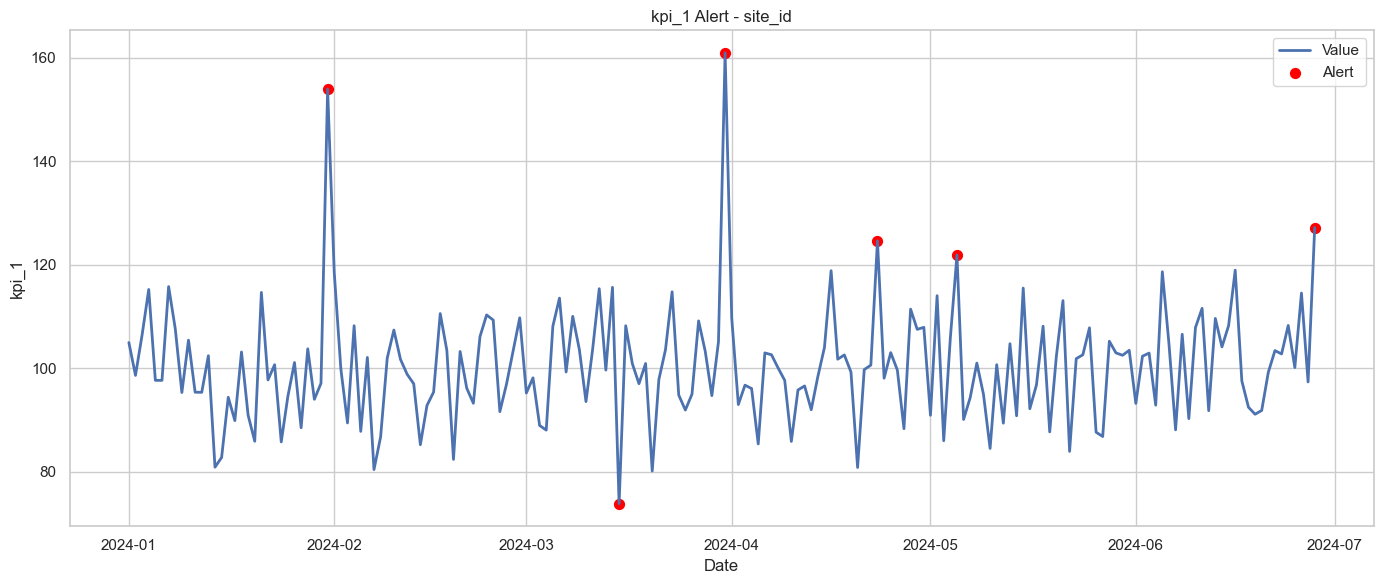

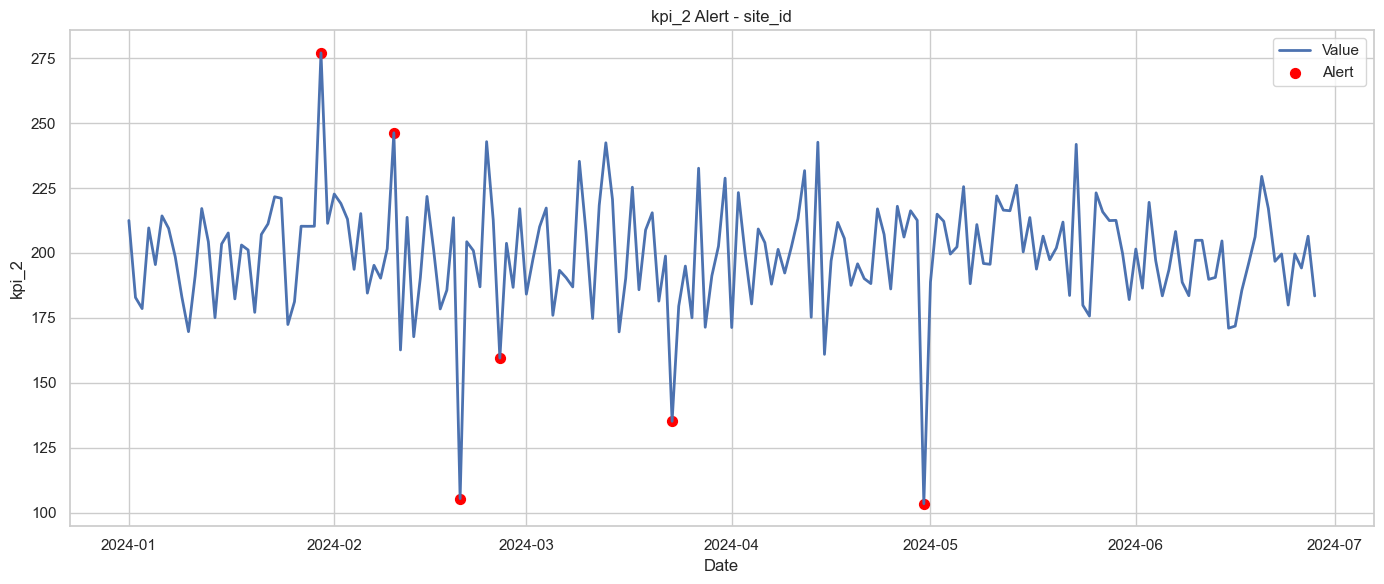

In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

def detect_anomalies(df, date_col, kpi_cols, level=None, granularity='D', contamination=0.03):
    df[date_col] = pd.to_datetime(df[date_col])
    group_cols = [level] if level else []
    result = []
    for key, group in df.groupby(group_cols) if group_cols else [(None, df)]:
        ts = group.set_index(date_col).sort_index()
        ts_resampled = ts[kpi_cols].resample(granularity).mean().dropna()
        temp = []
        for kpi in kpi_cols:
            model = IsolationForest(contamination=contamination, random_state=42)
            pred = model.fit_predict(ts_resampled[[kpi]])
            df_kpi = ts_resampled[[kpi]].copy()
            df_kpi['type'] = kpi
            df_kpi['value'] = df_kpi[kpi]
            df_kpi['anomaly'] = np.where(pred == -1, 1, 0)
            df_kpi = df_kpi.drop(columns=[kpi])
            temp.append(df_kpi)
        df_long = pd.concat(temp)
        df_long = df_long.reset_index()
        if group_cols:
            for i, col in enumerate(group_cols):
                df_long[col] = key[i] if isinstance(key, tuple) else key
        result.append(df_long)
    return pd.concat(result, ignore_index=True)

def plot_anomaly(df, group=None):
    sns.set(style='whitegrid')
    kpis = df['type'].unique()
    for kpi in kpis:
        subset = df[df['type'] == kpi]
        plt.figure(figsize=(14, 6))
        title = f"{kpi} Alert"
        if group:
            subset = subset[subset[group].notna()]
            title += f" - {group}"
        plt.plot(subset['date'], subset['value'], label='Value', linewidth=2)
        plt.scatter(subset[subset['anomaly'] == 1]['date'],
                    subset[subset['anomaly'] == 1]['value'],
                    color='red', s=50, label='Alert')
        plt.xlabel('Date')
        plt.ylabel(kpi)
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    np.random.seed(42)
    dates = pd.date_range(start='2024-01-01', periods=180, freq='D')
    data = []
    for region in ['A', 'B']:
        for site in range(3):
            kpi1 = np.random.normal(100, 10, len(dates))
            kpi2 = np.random.normal(200, 20, len(dates))
            kpi1[[30, 90]] += 60
            kpi2[[50, 120]] -= 80
            df_temp = pd.DataFrame({
                'date': dates,
                'region': region,
                'site_id': f"{region}_{site}",
                'kpi_1': kpi1,
                'kpi_2': kpi2
            })
            data.append(df_temp)
    df_all = pd.concat(data, ignore_index=True)
    print(df_all.head(3))
    out = detect_anomalies(df_all, date_col='date', kpi_cols=['kpi_1', 'kpi_2'],
                           level='site_id', granularity='D', contamination=0.03)
    plot_anomaly(out[out['site_id'] == 'A_0'], group='site_id')

In [13]:
df_all

,date,region,site_id,kpi_1,kpi_2
0,2024-01-01,A,A_0,104.967142,212.513347
1,2024-01-02,A,A_0,98.617357,182.856849
2,2024-01-03,A,A_0,106.476885,178.582150
3,2024-01-04,A,A_0,115.230299,209.649448
4,2024-01-05,A,A_0,97.658466,195.530744
...,...,...,...,...,...
1075,2024-06-24,B,B_2,96.114815,187.672772
1076,2024-06-25,B,B_2,111.241127,192.496072
1077,2024-06-26,B,B_2,109.475265,193.645698
1078,2024-06-27,B,B_2,92.271223,225.632876


In [14]:
out

,date,type,value,anomaly,site_id
0,2024-01-01,kpi_1,104.967142,0,A_0
1,2024-01-02,kpi_1,98.617357,0,A_0
2,2024-01-03,kpi_1,106.476885,0,A_0
3,2024-01-04,kpi_1,115.230299,0,A_0
4,2024-01-05,kpi_1,97.658466,0,A_0
...,...,...,...,...,...
2155,2024-06-24,kpi_2,187.672772,0,B_2
2156,2024-06-25,kpi_2,192.496072,0,B_2
2157,2024-06-26,kpi_2,193.645698,0,B_2
2158,2024-06-27,kpi_2,225.632876,0,B_2


In [15]:
out[out['anomaly'] == 1]

,date,type,value,anomaly,site_id
30,2024-01-31,kpi_1,153.982934,1,A_0
74,2024-03-15,kpi_1,73.802549,1,A_0
90,2024-03-31,kpi_1,160.970775,1,A_0
113,2024-04-23,kpi_1,124.632421,1,A_0
125,2024-05-05,kpi_1,121.904556,1,A_0
...,...,...,...,...,...
2026,2024-02-16,kpi_2,236.010224,1,B_2
2030,2024-02-20,kpi_2,136.142452,1,B_2
2035,2024-02-25,kpi_2,255.193201,1,B_2
2100,2024-04-30,kpi_2,127.528191,1,B_2
